# Image Classification Data Preprocessing 🗂️
### Spécialisé pour différencier les photos des dessins, peintures, schémas et textes 🪄

In [3]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import albumentations as A
from PIL import Image
import shutil
import random
from pathlib import Path

print("current working directory: ", os.getcwd())

current working directory:  /home/kevin


In [ ]:
# PATHS
WINDOWS_DIR = '/mnt/c/Users/NyveK/Downloads/Datasets/Datasets/livrable1/raw'    # Ici on attend le path du dataset sur Windows (mais depuis les disqué monté WSL pour plus de rapidité)
TARGET_WSL_DIR = '/home/kevin/datasets/livrable1/raw'
TARGET_PROCESSED_DIR = '/home/kevin/datasets/livrable1/processed'


In [7]:

#On verifie si le dossier existe deja
if not os.path.exists(TARGET_WSL_DIR):
    os.makedirs(TARGET_WSL_DIR)

#On copie le dataset brute dans WSL
shutil.copytree(WINDOWS_DIR, TARGET_WSL_DIR,dirs_exist_ok=True)

'/home/kevin/datasets/livrable1/raw'

In [8]:
# Check JPEG integrity and repair if needed
def check_and_repair_jpeg(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verify the image
        return True
    except (IOError, SyntaxError) as e:
        print(f"Corrupted JPEG file: {file_path}")
        return False
    
for file in os.listdir(TARGET_WSL_DIR + '/Painting'):
    file_path = os.path.join(TARGET_WSL_DIR + '/Painting', file)
    if not check_and_repair_jpeg(file_path):
        print(f"Repairing {file_path}")
        try:
            img = Image.open(file_path)
            img.save(file_path, "JPEG")
        except Exception as e:
            print(f"Failed to repair {file_path}: {e}")
    

In [9]:

# Configuration des paramètres
IMAGE_SIZE = 224  # Taille standard pour ResNet
BATCH_SIZE = 32
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Définir les chemins d'accès
BASE_DIR = TARGET_WSL_DIR
OUTPUT_DIR = TARGET_PROCESSED_DIR

Exploration du dataset dans /home/kevin/datasets/livrable1/raw
Classes trouvées: ['Photo', 'Sketch', 'Painting', 'Schematics', 'Text']


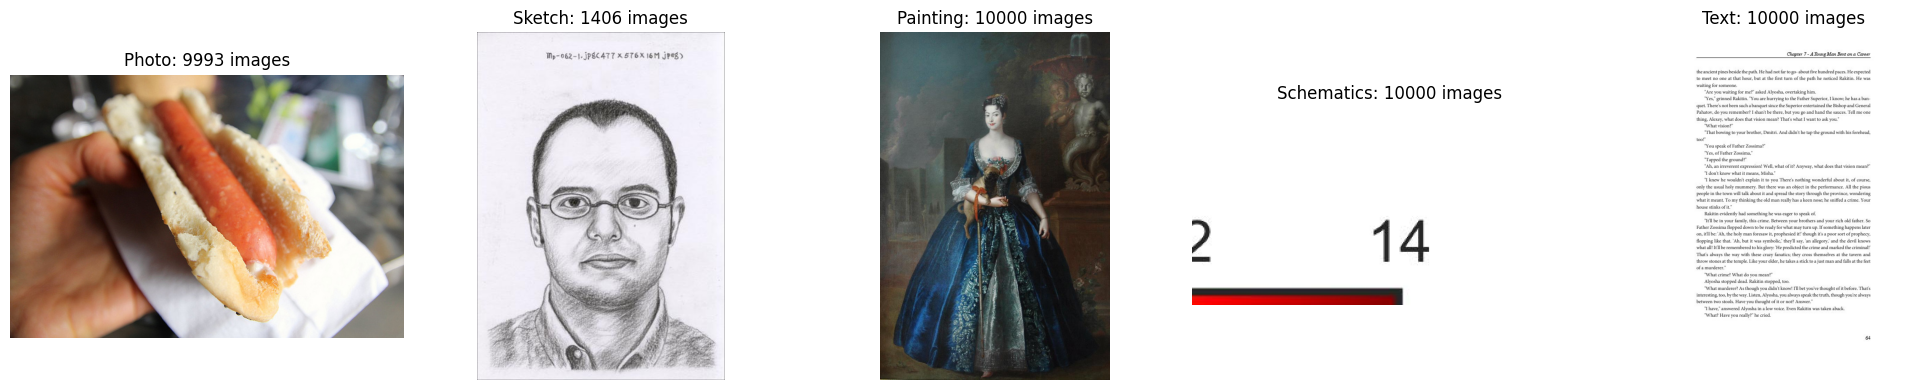


Statistiques par classe:
Photo: 9993 images (24.1%)
Sketch: 1406 images (3.4%)
Painting: 10000 images (24.2%)
Schematics: 10000 images (24.2%)
Text: 10000 images (24.2%)

Total des images: 41399


In [10]:
# Créer les dossiers de sortie s'ils n'existent pas
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
for split in ['train', 'val', 'test']:
    Path(os.path.join(OUTPUT_DIR, split)).mkdir(exist_ok=True)
    
# 1. Exploration des données
def explore_dataset(base_dir):
    """Explore le dataset et affiche des statistiques sur les classes."""
    print(f"Exploration du dataset dans {base_dir}")
    
    classes = os.listdir(base_dir)
    classes = [c for c in classes if os.path.isdir(os.path.join(base_dir, c))]
    
    print(f"Classes trouvées: {classes}")
    
    class_stats = {}
    total_images = 0
    
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 4))
    
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        num_images = len(images)
        total_images += num_images
        class_stats[class_name] = num_images
        
        # Afficher un exemple d'image pour chaque classe
        if num_images > 0:
            sample_img_path = os.path.join(class_dir, images[0])
            img = plt.imread(sample_img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{class_name}: {num_images} images")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\nStatistiques par classe:")
    for class_name, count in class_stats.items():
        print(f"{class_name}: {count} images ({count / total_images * 100:.1f}%)")
    
    print(f"\nTotal des images: {total_images}")
    
    return classes, class_stats

# Exploration du dataset
classes, class_stats = explore_dataset(BASE_DIR)



Analyse des propriétés des images...


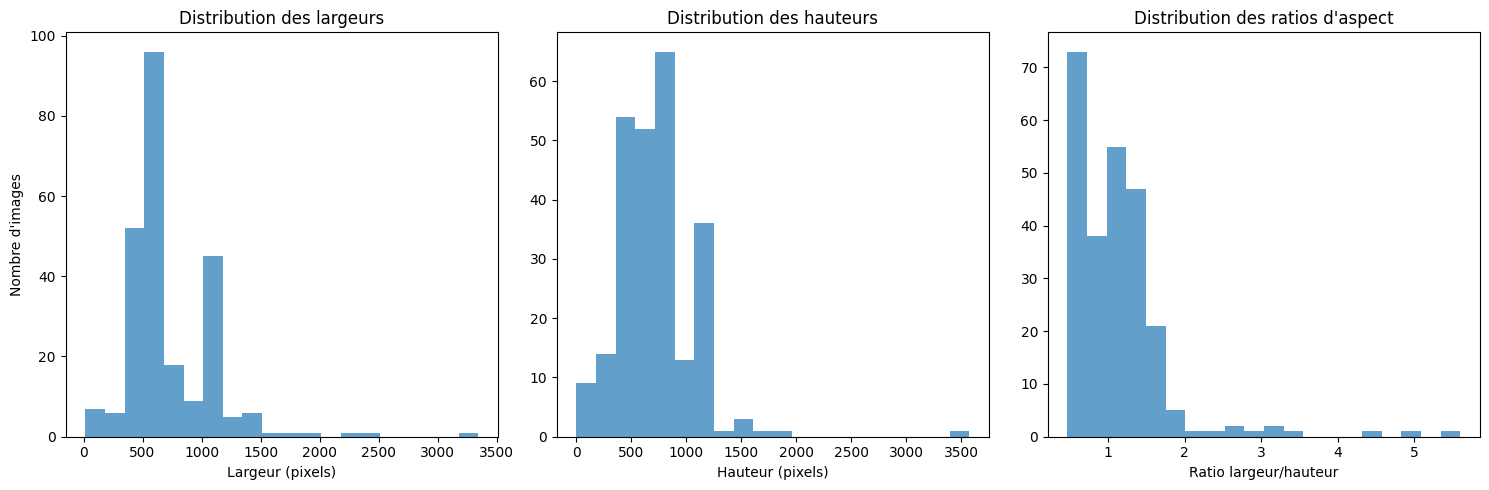


Distribution des modes couleur:
  RGB: 212 images (84.8%)
  RGBA: 0 images (0.0%)
  L: 38 images (15.2%)
  autres: 0 images (0.0%)

Dimensions moyennes: 732x726 pixels
Dimensions médianes: 629x684 pixels


In [11]:

# 2. Analyse des caractéristiques des images
def analyze_image_properties(base_dir, classes, sample_size=50):
    """Analyse les propriétés des images (taille, mode couleur, etc.) pour chaque classe."""
    print("\nAnalyse des propriétés des images...")
    
    image_sizes = []
    aspect_ratios = []
    color_modes = {'RGB': 0, 'RGBA': 0, 'L': 0, 'autres': 0}
    
    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        # Échantillonner des images pour analyse
        if len(images) > sample_size:
            sample_images = random.sample(images, sample_size)
        else:
            sample_images = images
        
        for img_file in sample_images:
            img_path = os.path.join(class_dir, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    image_sizes.append((width, height))
                    aspect_ratios.append(width / height)
                    
                    if img.mode in color_modes:
                        color_modes[img.mode] += 1
                    else:
                        color_modes['autres'] += 1
            except Exception as e:
                print(f"Erreur lors de l'analyse de {img_path}: {e}")
    
    # Visualiser les distributions de taille
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist([w for w, h in image_sizes], bins=20, alpha=0.7)
    plt.title('Distribution des largeurs')
    plt.xlabel('Largeur (pixels)')
    plt.ylabel('Nombre d\'images')
    
    plt.subplot(1, 3, 2)
    plt.hist([h for w, h in image_sizes], bins=20, alpha=0.7)
    plt.title('Distribution des hauteurs')
    plt.xlabel('Hauteur (pixels)')
    
    plt.subplot(1, 3, 3)
    plt.hist(aspect_ratios, bins=20, alpha=0.7)
    plt.title('Distribution des ratios d\'aspect')
    plt.xlabel('Ratio largeur/hauteur')
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les modes couleur
    print("\nDistribution des modes couleur:")
    for mode, count in color_modes.items():
        print(f"  {mode}: {count} images ({count / sum(color_modes.values()) * 100:.1f}%)")
    
    # Calcul des dimensions moyennes et médianes
    widths = [w for w, h in image_sizes]
    heights = [h for w, h in image_sizes]
    
    print(f"\nDimensions moyennes: {int(np.mean(widths))}x{int(np.mean(heights))} pixels")
    print(f"Dimensions médianes: {int(np.median(widths))}x{int(np.median(heights))} pixels")
    
    return image_sizes, aspect_ratios, color_modes

# Analyser les propriétés des images
image_sizes, aspect_ratios, color_modes = analyze_image_properties(BASE_DIR, classes)


In [12]:

# 3. Prétraitement des images
def preprocess_image(img_path, target_size=(224, 224), preserve_aspect_ratio=True):
    """
    Prétraite une image selon l'état de l'art pour la reconnaissance de photos.
    
    Arguments:
        img_path: Chemin vers l'image
        target_size: Taille cible (hauteur, largeur)
        preserve_aspect_ratio: Conserver le ratio d'aspect lors du redimensionnement
        
    Retourne:
        Image prétraitée normalisée
    """
    # Charger l'image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Impossible de charger l'image: {img_path}")
    
    # Convertir de BGR à RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if preserve_aspect_ratio:
        # Redimensionner tout en préservant le ratio d'aspect
        h, w = img.shape[:2]
        if h > w:
            new_h, new_w = target_size[0], int(w * target_size[0] / h)
        else:
            new_h, new_w = int(h * target_size[1] / w), target_size[1]
        
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Ajouter un padding pour obtenir une image carrée
        delta_w = target_size[1] - new_w
        delta_h = target_size[0] - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        
        img = cv2.copyMakeBorder(img, top, bottom, left, right, 
                                 cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        # Redimensionner directement à la taille cible
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    
    # Normalisation avancée (utilisée par ResNet)
    img = img.astype(np.float32) / 255.0
    
    
    return img

# Définir les augmentations pour l'entraînement (spécifiquement adaptées à la détection de photos)
def get_augmentations():
    """
    Crée des transformations d'augmentation de données spécialement adaptées 
    pour différencier les photos des dessins/peintures/schémas/textes
    """
    train_transform = A.Compose([
        A.RandomResizedCrop(size=(IMAGE_SIZE,IMAGE_SIZE), scale=(0.8, 1.0)), 
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=30, val_shift_limit=20),
        ], p=0.7),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 5)),
            A.MedianBlur(blur_limit=5),
        ], p=0.2),  # Flou léger pour simuler des photos de différentes qualités
        A.ImageCompression(quality_lower=85, quality_upper=100, p=0.3),  # Simule compression JPEG
        A.ToFloat(max_value=255)
    ])
    
    valid_transform = A.Compose([
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.ToFloat(max_value=255)
    ])
    
    return train_transform, valid_transform
    

# 4. Division du dataset et préparation
def prepare_dataset(base_dir, output_dir, classes, val_split=0.15, test_split=0.15):
    """
    Divise le dataset en ensembles d'entraînement, validation et test,
    et prépare les images pour l'entraînement.
    """
    print("\nPréparation du dataset...")
    print("IMAGE_SIZE:", IMAGE_SIZE)
    print("BATCH_SIZE:", BATCH_SIZE)
    train_transform, valid_transform = get_augmentations()
    
    # Création des dossiers pour les ensembles train/val/test
    os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)
    
    for class_name in classes:
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)
    
    # Création d'un DataFrame pour traquer les images et leurs attributions
    dataset_info = []
    
    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        # Division en ensembles d'entraînement, validation et test
        train_imgs, temp_imgs = train_test_split(images, test_size=val_split+test_split, random_state=SEED)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_split/(val_split+test_split), random_state=SEED)
        
        print(f"Classe {class_name}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")
        
        # Traiter les images d'entraînement avec augmentation
        for img_file in tqdm(train_imgs, desc=f"Traitement {class_name} (train)"):
            img_path = os.path.join(class_dir, img_file)
            try:
                # Charger l'image originale
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Appliquer la transformation d'augmentation
                augmented = train_transform(image=image)
                processed_img = augmented['image']
                
                # Sauvegarder l'image transformée
                output_path = os.path.join(output_dir, 'train', class_name, img_file)
                plt.imsave(output_path, processed_img)
                
                dataset_info.append({
                    'filename': img_file,
                    'class': class_name,
                    'split': 'train',
                    'path': output_path
                })
            except Exception as e:
                print(f"Erreur lors du traitement de {img_path}: {e}")
        
        # Traiter les images de validation et de test sans augmentation
        for split, img_list in [('val', val_imgs), ('test', test_imgs)]:
            for img_file in tqdm(img_list, desc=f"Traitement {class_name} ({split})"):
                img_path = os.path.join(class_dir, img_file)
                try:
                    # Charger l'image originale
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Appliquer la transformation de validation
                    augmented = valid_transform(image=image)
                    processed_img = augmented['image']
                    
                    # Sauvegarder l'image transformée
                    output_path = os.path.join(output_dir, split, class_name, img_file)
                    plt.imsave(output_path, processed_img)
                    
                    dataset_info.append({
                        'filename': img_file,
                        'class': class_name,
                        'split': split,
                        'path': output_path
                    })
                except Exception as e:
                    print(f"Erreur lors du traitement de {img_path}: {e}")
    
    # Créer un DataFrame avec les informations du dataset
    df = pd.DataFrame(dataset_info)
    df.to_csv(os.path.join(output_dir, 'dataset_info.csv'), index=False)
    
    print("\nPréparation du dataset terminée !")
    print(f"Données sauvegardées dans: {output_dir}")
    
    # Afficher un résumé
    print("\nRésumé du dataset préparé:")
    summary = df.groupby(['split', 'class']).size().unstack()
    print(summary)
    
    return df

# Préparer le dataset
dataset_df = prepare_dataset(BASE_DIR, OUTPUT_DIR, classes)



Préparation du dataset...
IMAGE_SIZE: 224
BATCH_SIZE: 32
Classe Photo: 6995 train, 1499 val, 1499 test


/tmp/ipykernel_44778/2065420889.py:67: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=85, quality_upper=100, p=0.3),  # Simule compression JPEG


Traitement Photo (train):   0%|          | 0/6995 [00:00<?, ?it/s]

Traitement Photo (val):   0%|          | 0/1499 [00:00<?, ?it/s]

Traitement Photo (test):   0%|          | 0/1499 [00:00<?, ?it/s]

Classe Sketch: 984 train, 211 val, 211 test


Traitement Sketch (train):   0%|          | 0/984 [00:00<?, ?it/s]

Traitement Sketch (val):   0%|          | 0/211 [00:00<?, ?it/s]

Traitement Sketch (test):   0%|          | 0/211 [00:00<?, ?it/s]

Classe Painting: 7000 train, 1500 val, 1500 test


Traitement Painting (train):   0%|          | 0/7000 [00:00<?, ?it/s]

Traitement Painting (val):   0%|          | 0/1500 [00:00<?, ?it/s]

Traitement Painting (test):   0%|          | 0/1500 [00:00<?, ?it/s]

Classe Schematics: 7000 train, 1500 val, 1500 test


Traitement Schematics (train):   0%|          | 0/7000 [00:00<?, ?it/s]

Traitement Schematics (val):   0%|          | 0/1500 [00:00<?, ?it/s]

Traitement Schematics (test):   0%|          | 0/1500 [00:00<?, ?it/s]

Classe Text: 7000 train, 1500 val, 1500 test


Traitement Text (train):   0%|          | 0/7000 [00:00<?, ?it/s]

Traitement Text (val):   0%|          | 0/1500 [00:00<?, ?it/s]

Traitement Text (test):   0%|          | 0/1500 [00:00<?, ?it/s]


Préparation du dataset terminée !
Données sauvegardées dans: /home/kevin/datasets/livrable1/processed

Résumé du dataset préparé:
class  Painting  Photo  Schematics  Sketch  Text
split                                           
test       1500   1499        1500     211  1500
train      7000   6995        7000     984  7000
val        1500   1499        1500     211  1500



Exemples d'images prétraitées:


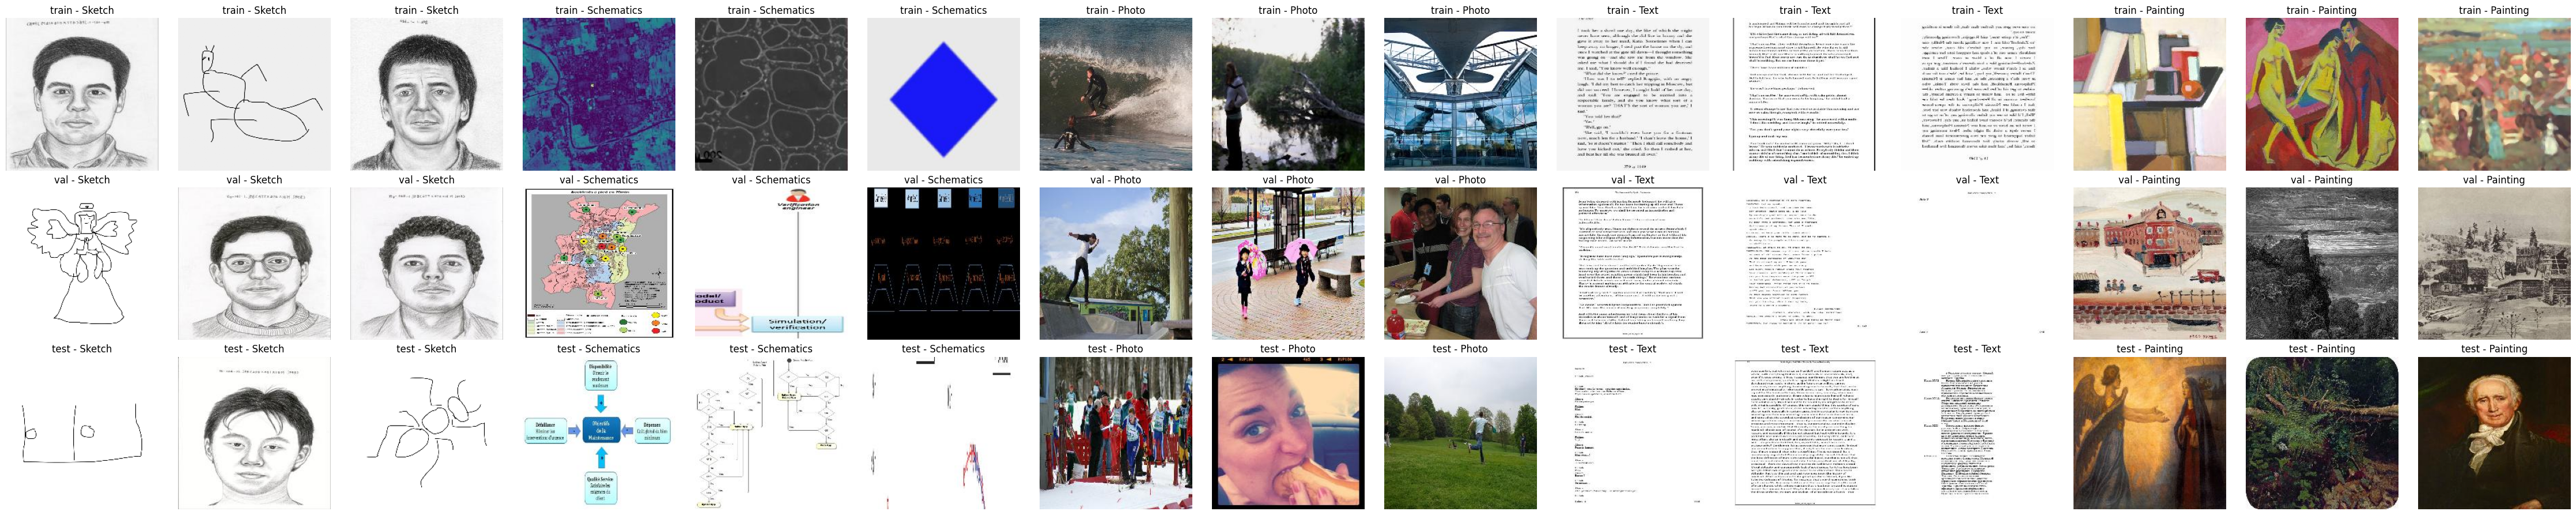


Création des générateurs de données...
Found 28979 images belonging to 5 classes.
Found 6209 images belonging to 5 classes.
Found 6210 images belonging to 5 classes.

Générateurs de données créés !
Classes mappées: {'Painting': 0, 'Photo': 1, 'Schematics': 2, 'Sketch': 3, 'Text': 4}


In [46]:

# 5. Vérifier quelques exemples d'images prétraitées
def display_processed_images(dataset_df, num_examples=3):
    """Affiche des exemples d'images prétraitées pour chaque classe et split."""
    print("\nExemples d'images prétraitées:")
    
    splits = dataset_df['split'].unique()
    classes = dataset_df['class'].unique()
    
    num_rows = len(splits)
    num_cols = len(classes) * num_examples
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    
    for i, split in enumerate(splits):
        for j, class_name in enumerate(classes):
            # Filtrer les images de cette classe et ce split
            subset = dataset_df[(dataset_df['split'] == split) & (dataset_df['class'] == class_name)]
            
            if len(subset) > 0:
                # Sélectionner quelques exemples aléatoires
                examples = subset.sample(min(num_examples, len(subset)))
                
                for k, (_, example) in enumerate(examples.iterrows()):
                    ax_idx = i, j * num_examples + k
                    try:
                        img = plt.imread(example['path'])
                        if len(axes.shape) == 1:  # Si une seule ligne
                            axes[ax_idx[1]].imshow(img)
                            axes[ax_idx[1]].set_title(f"{split} - {class_name}")
                            axes[ax_idx[1]].axis('off')
                        else:
                            axes[ax_idx].imshow(img)
                            axes[ax_idx].set_title(f"{split} - {class_name}")
                            axes[ax_idx].axis('off')
                    except Exception as e:
                        print(f"Erreur lors de l'affichage de {example['path']}: {e}")
    
    plt.tight_layout()
    plt.show()

# Afficher des exemples d'images prétraitées
display_processed_images(dataset_df)

# 6. Créer des générateurs de données TensorFlow
def create_data_generators(output_dir, batch_size=32):
    """Crée des générateurs de données TensorFlow à partir des images prétraitées."""
    print("\nCréation des générateurs de données...")
    
    # Configuration pour la génération de données
    train_datagen = ImageDataGenerator(
        # Nous avons déjà normalisé les données lors du prétraitement
    )
    
    valid_datagen = ImageDataGenerator(
        # Pas d'augmentation pour la validation/test
    )
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(output_dir, 'train'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )
    
    val_generator = valid_datagen.flow_from_directory(
        os.path.join(output_dir, 'val'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = valid_datagen.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    print("\nGénérateurs de données créés !")
    print(f"Classes mappées: {train_generator.class_indices}")
    
    return train_generator, val_generator, test_generator

# Créer les générateurs de données
train_gen, val_gen, test_gen = create_data_generators(OUTPUT_DIR, batch_size=BATCH_SIZE)


In [ ]:

# 7. Sauvegarder la configuration pour l'entraînement
def save_training_config(output_dir, class_indices, image_size, batch_size):
    """Sauvegarde la configuration pour l'entraînement."""
    config = {
        'image_size': image_size,
        'batch_size': batch_size,
        'classes': class_indices,
        'num_classes': len(class_indices),
        'preprocessing': 'ResNet-like normalization',
        'augmentation': 'Rotaltion, flip, brightness/contrast, blur, compression'
    }
    
    import json
    with open(os.path.join(output_dir, 'training_config.json'), 'w') as f:
        json.dump(config, f, indent=4)
    
    print(f"\nConfiguration sauvegardée dans {output_dir}/training_config.json")

# Sauvegarder la configuration
save_training_config(OUTPUT_DIR, train_gen.class_indices, IMAGE_SIZE, BATCH_SIZE)

print("\nPrétraitement des données terminé avec succès !")
print(f"Le dataset est prêt pour l'entraînement d'un modèle ResNet pour la classification de photos.")



Configuration sauvegardée dans /home/kevin/datasets/livrable1/processed/training_config.json

Prétraitement des données terminé avec succès !
Le dataset est prêt pour l'entraînement d'un modèle ResNet pour la classification de photos.
